In [32]:
import os
import sys

sys.path.append('.')  # Add the parent directory of LLM_Evaluations to the Python path
from statistics_plots_analysis_utils import *

def plot_group(plot_type, group_df, group_num, model_name, pair_columns, **kwargs):
    '''Plot comparison of expert and model data for a specified group and plot type.'''
    if plot_type not in ['countplot', 'histplot', 'boxplot']:
        raise ValueError("Invalid plot_type. Supported types: 'countplot', 'histplot', 'boxplot'.")
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    col1 = pair_columns[0]
    col2 = pair_columns[1]

    if plot_type == 'boxplot':
        suptitle = f'Group {group_num} Box Plots'
        df1 = group_df[col1]                    # pd.Series
        df2 = group_df[col2]
    elif plot_type in ['countplot', 'histplot']:
        suptitle = f'Group {group_num} Score Distributions'
        df1 = group_df[[col1]]                  # DataFrame
        df2 = group_df[[col2]]

    create_plot(plot_type, data=df1, ax=axes[0], color='skyblue', 
                 x=col1,
                 title='Experts',
                 **kwargs)

    create_plot(plot_type, data=df2, ax=axes[1], color='salmon', 
                 x=col2, 
                 title=f'{model_name}',
                 **kwargs)

    fig.suptitle(suptitle)

    plt.tight_layout()
    plt.show()

## Evaluate LLM Evaluation

### Prepare Three Groups

#### Load Expert Scores

In [ ]:
# videos_info_file = '../../Getting_Transcripts/merged_filtered_videos_transcripts.csv'
# videos_info_df = pd.read_csv(videos_info_file, usecols=['Video ID'], encoding='utf-8')
# original_experts_file = '../../../Videos_and_DISCERN_data/videos_info_and_scores.xlsx'
# score_columns_to_read = ['Video ID', 'Topic', 'DISCERN1', 'DISCERN2'] + [f'DISCERN1 Q{i}' for i in range(1, 16)] + [f'DISCERN2 Q{i}' for i in range(1, 16)]
# experts_df = pd.read_excel(original_experts_file, usecols=score_columns_to_read)
# experts_df = merge_dataframes(videos_info_df, experts_df, experts_df.columns)

# experts_df.rename(columns=lambda x: x.replace('DISCERN', 'Expert'), inplace=True)

# # Find the indices of rows where any of the Q1 to Q15 columns have non-null values, to fill the NaN with 1
# # This is to fill Cluster Headque N/A questions with 1
# indices = experts_df[EXPERT1_COLUMNS].notna().any(axis=1)
# experts_df.loc[indices, EXPERT1_COLUMNS] = experts_df.loc[indices, EXPERT1_COLUMNS].fillna(1)
# # Sum the total after filling Nan with 1
# experts_df.loc[indices, 'Expert1'] = experts_df.loc[indices, EXPERT1_COLUMNS].sum(axis=1)

# # Calculate the mean of 'Expert1' and 'Expert2' columns where 'Expert2' is not NaN, and round it up
# mean_discern = np.where(experts_df['Expert2'].notnull(), 
#                         experts_df[['Expert1', 'Expert2']].mean(axis=1),
#                         experts_df['Expert1'])
# experts_df.insert(4, 'Experts_Avg', mean_discern)

# experts_df.to_csv('../../../Videos_and_DISCERN_data/filtered_experts_scores.csv', index=False)
# print(experts_df.shape)
# experts_df.head()

In [27]:
# experts_file = '../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv'
experts_file = '../../../Videos_and_DISCERN_data/filtered_experts_scores.csv'
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Load LLM Scores

In [4]:
agreement_coef = 'Brennan-Prediger Kappa'
model_proper_name = 'gpt-4-turbo'
model_file_name = model_proper_name + '-response.csv'
models_dir = '../../../Results/LLMs_Responses'
model_file = os.path.join(models_dir, model_file_name)

question_columns = MODEL_15_SCORE_COLUMNS
# question_columns = [f'Q{i}' for i in range(1,6)]
model_df = pd.read_csv(model_file, encoding='utf-8', usecols=['Video ID'] + question_columns)

model_df = merge_dataframes(model_df, experts_df, ['Video ID', 'Topic'])

# Reorder columns
new_order = ['Video ID', 'Topic'] + MODEL_15_SCORE_COLUMNS
model_df = model_df.reindex(columns=new_order)

print('Shape:', model_df.shape)
model_df.head()

Shape: (276, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,5,4,5,1,5,4,2,5,5,4,4,5,4,5,4
1,95T3ABnnhOs,Nocturnal Enuresis,5,5,5,2,5,4,2,4,4,4,2,1,3,4,4
2,n8kmsN0em90,Nocturnal Enuresis,5,5,5,1,5,4,1,2,2,2,2,4,2,5,2
3,XFitRQ9S68Q,Nocturnal Enuresis,4,5,5,5,4,4,2,4,4,4,4,1,3,5,4
4,qhNV0YhvaNQ,Nocturnal Enuresis,4,4,5,2,4,2,2,5,2,2,1,2,1,2,2


### Group A Analysis
Group A: Scores out of 5. Experts individual scores are not provided

In [5]:
categories = list(range(0,6))

#### Split Group A

In [6]:
questions_to_keep = ['Q1', 'Q4', 'Q6', 'Q7', 'Q8']
# questions_to_keep = [f'Q{i}' for i in range(1,6)]
columns_to_keep = ['Video ID', 'Topic'] + questions_to_keep

model_groupA_df = filter_df_by_topics(model_df, TOPICS, ['NE', 'DE'],
                                      return_cols=columns_to_keep)

print(f'Group 1 shape: {model_groupA_df.shape}')
model_groupA_df.head(3)

Group 1 shape: (82, 7)


,Video ID,Topic,Q1,Q4,Q6,Q7,Q8
0,OWtlKJbg_Pc,Nocturnal Enuresis,5,1,4,2,5
1,95T3ABnnhOs,Nocturnal Enuresis,5,2,4,2,4
2,n8kmsN0em90,Nocturnal Enuresis,5,1,4,1,2


#### Process mDISCERN Scores: Binarization, Summation and Merging with Expert Scores

In [7]:
questions_to_keep = ['Q1', 'Q4', 'Q6', 'Q7', 'Q8']
# questions_to_keep = [f'Q{i}' for i in range(1,6)]
columns_to_keep = ['Video ID', 'Topic'] + questions_to_keep

# Select only the columns to keep
model_groupA_df = model_groupA_df[columns_to_keep]

# Apply the convert_value function to all elements in columns Q1 to Q15
for column in questions_to_keep:
    model_groupA_df.loc[:, column] = model_groupA_df[column].apply(binarize_value)

model_groupA_df['Model Total'] = model_groupA_df[questions_to_keep].sum(axis=1)

model_groupA_df = merge_dataframes(model_groupA_df, experts_df, ['Video ID'] + EXPERT_TOTAL_COLUMNS)

model_groupA_df['Expert2'] = model_groupA_df['Expert2'].astype(int)

print(f'Group A shape: {model_groupA_df.shape}')
model_groupA_df.head(2)

Group A shape: (82, 11)


,Video ID,Topic,Q1,Q4,Q6,Q7,Q8,Model Total,Expert1,Expert2,Experts_Avg
0,OWtlKJbg_Pc,Nocturnal Enuresis,1,0,1,0,1,3,2,2,2.0
1,95T3ABnnhOs,Nocturnal Enuresis,1,0,1,0,1,3,1,1,1.0


#### Descriptive Statistics

Box-plot

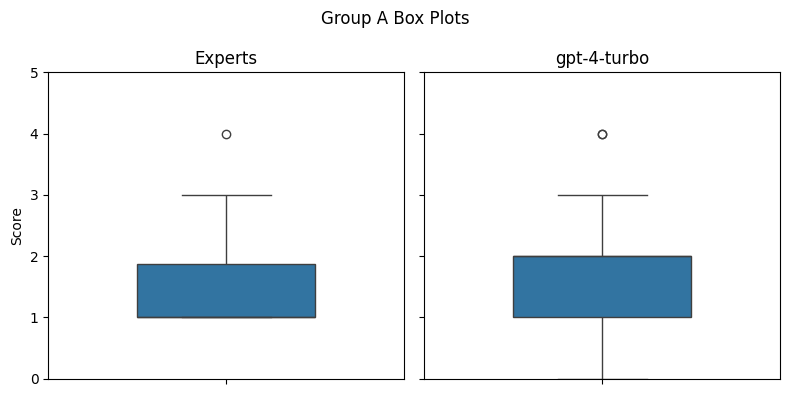

Descriptive Statistics:


,Experts_Avg,Model Total
count,82.00,82.00
mean,1.32,1.59
std,0.55,1.07
min,1.00,0.00
25%,1.00,1.00
50%,1.00,2.00
75%,1.88,2.00
max,4.00,4.00


In [8]:
plot_group('boxplot', model_groupA_df, 'A', model_proper_name, ('Experts_Avg', 'Model Total'),
           ylabel='Score', ylim=(0,5), width=0.5)

print('Descriptive Statistics:')
statA_df = model_groupA_df[['Experts_Avg', 'Model Total']].describe().round(2)
statA_df

Histogram

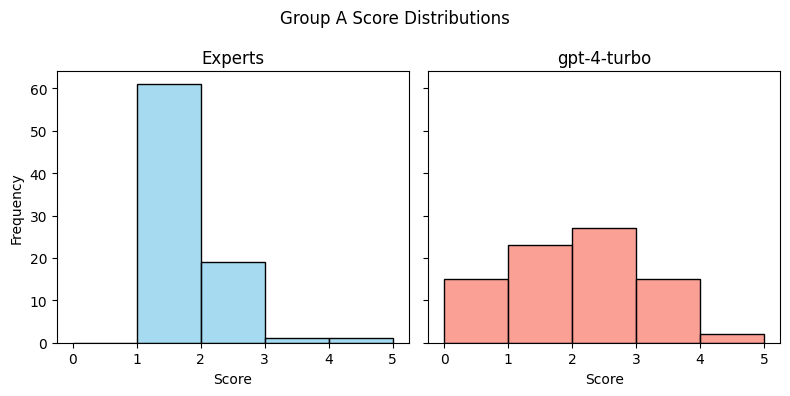

In [9]:
bins = categories

plot_group('histplot', model_groupA_df, 'A', model_proper_name, ('Experts_Avg', 'Model Total'),
           xlabel='Score', ylabel='Frequency', bins=bins)

Similarity Statistics

In [10]:
col1 = 'Expert1'
col2 = 'Expert2'
stat_expert1_vs_expert2 = calculate_statistics(model_groupA_df, col1, col2, categories)

col1 = 'Experts_Avg'
col2 = 'Model Total'
stat_experts_vs_model = calculate_statistics(model_groupA_df, col1, col2, categories)

merged_stat_df = pd.DataFrame.from_dict({
    'Expert1_vs_Expert2': stat_expert1_vs_expert2,
    'Experts_vs_Model': stat_experts_vs_model
}).rename_axis('Metric').round(2)

merged_stat_df.T

Metric,Brennan-Prediger Kappa,Weighted Kappa,Spearman's Rho,ICC3,Gwet's AC2
Expert1_vs_Expert2,0.99,0.92,0.89,0.93,0.99
Experts_vs_Model,0.77,0.30,0.37,0.29,0.85


### Group B Analysis
Group B: Total scores out of 75.

In [11]:
categories = list(range(15,76))

#### Split Group B

In [12]:
model_groupB_df = filter_df_by_topics(model_df, TOPICS, ['SB', 'FF', 'CH', 'TF', 'PN'], 
                                      return_cols=['Video ID', 'Topic', *MODEL_15_SCORE_COLUMNS])

print(f'Group B shape: {model_groupB_df.shape}')
model_groupB_df.head(3)

Group B shape: (194, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,t6PP67AsJaI,Spina Bifida,2,5,5,2,5,2,1,2,4,2,2,1,2,2,2
1,TuLAGDTpR6Y,Spina Bifida,5,5,5,2,5,2,2,2,5,4,3,2,4,2,2
2,4xOGmPla7e0,Spina Bifida,5,5,5,4,5,4,2,5,5,4,5,2,4,5,2


#### Process Scores: Summation and Merging with Expert Scores

In [13]:
model_groupB_df['Model Total'] = model_groupB_df[MODEL_15_SCORE_COLUMNS].sum(axis=1)

model_groupB_df = merge_dataframes(model_groupB_df, experts_df, 
                                            selected_columns=['Video ID'] + EXPERT_TOTAL_COLUMNS)

print(f'Group B shape: {model_groupB_df.shape}')
model_groupB_df.head(2)

Group B shape: (194, 21)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q10,Q11,Q12,Q13,Q14,Q15,Model Total,Expert1,Expert2,Experts_Avg
0,t6PP67AsJaI,Spina Bifida,2,5,5,2,5,2,1,2,...,2,2,1,2,2,2,39,26,25.0,25.5
1,TuLAGDTpR6Y,Spina Bifida,5,5,5,2,5,2,2,2,...,4,3,2,4,2,2,50,32,33.0,32.5


#### Descriptive Statistics

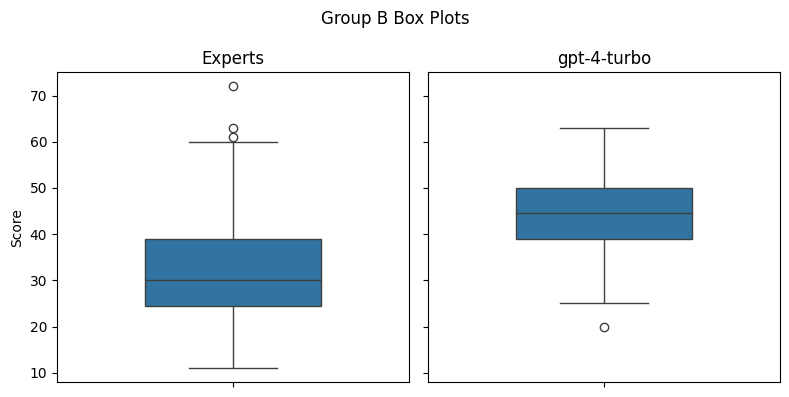

Descriptive Statistics:


,Experts_Avg,Model Total
count,194.00,194.00
mean,31.58,44.31
std,10.96,8.20
min,11.00,20.00
25%,24.50,39.00
50%,30.00,44.50
75%,39.00,50.00
max,72.00,63.00


In [14]:
plot_group('boxplot', model_groupB_df, 'B', model_proper_name, ('Experts_Avg', 'Model Total'),
           ylabel='Score', width=0.5)

print('Descriptive Statistics:')
statB_df = model_groupB_df[['Experts_Avg', 'Model Total']].describe().round(2)
statB_df

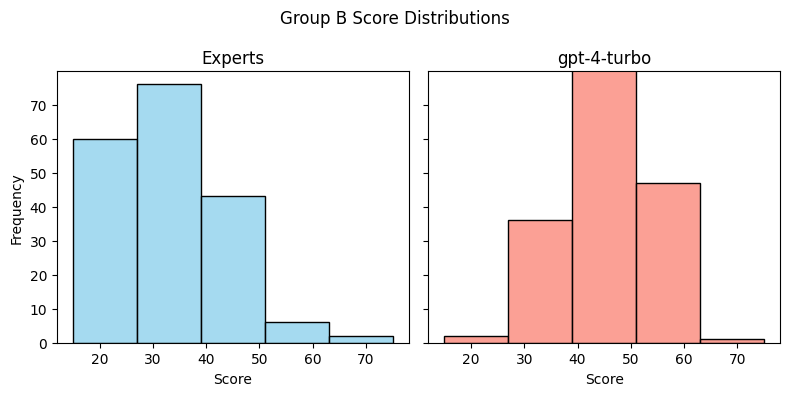

In [15]:
bins = list(range(15, 76, 12))

plot_group('histplot', model_groupB_df, 'B', model_proper_name, ('Experts_Avg', 'Model Total'),
           xlabel='Score', ylabel='Frequency', bins=bins)

In [16]:
col1 = 'Expert1'
col2 = 'Expert2'
stat_expert1_vs_expert2 = calculate_statistics(model_groupB_df, col1, col2, categories)

col1 = 'Experts_Avg'
col2 = 'Model Total'
stat_experts_vs_model = calculate_statistics(model_groupB_df, col1, col2, categories)

merged_stat_df = pd.DataFrame.from_dict({
    'Expert1_vs_Expert2': stat_expert1_vs_expert2,
    'Experts_vs_Model': stat_experts_vs_model
}).rename_axis('Metric').round(2)

merged_stat_df.T

Metric,Brennan-Prediger Kappa,Weighted Kappa,Spearman's Rho,ICC3,Gwet's AC2
Expert1_vs_Expert2,0.96,0.88,0.93,0.88,0.96
Experts_vs_Model,0.59,0.23,0.42,0.43,0.61


### Group C Analysis
Group C: individual 15 scores

In [17]:
categories = list(range(1,6))

#### Split Group C

In [18]:
model_groupC_df = filter_df_by_topics(model_df, TOPICS, ['CH', 'TF', 'PN'],
                                      return_cols=['Video ID', 'Topic', *MODEL_15_SCORE_COLUMNS])

print(f'Group C shape: {model_groupC_df.shape}')
model_groupC_df.head(3)

Group C shape: (133, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,WHGCRT9xgu0,Cluster Headache,4,5,5,2,5,3,2,5,2,2,2,2,3,2,3
1,0Fe0m0IF6r8,Cluster Headache,5,5,5,2,4,4,1,5,4,2,2,1,2,3,2
2,KtIeO9xn9G0,Cluster Headache,3,4,5,1,2,2,2,4,2,3,2,2,3,4,2


#### Process Scores: Summation and Merging with Expert Scores

In [19]:
experts_q_columns = EXPERT1_COLUMNS + EXPERT2_COLUMNS

model_groupC_df = merge_dataframes(model_groupC_df, experts_df,
                                            selected_columns=['Video ID'] + experts_q_columns)

print(f'Group C shape: {model_groupC_df.shape}')
model_groupC_df.head(2)

Group C shape: (133, 47)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,WHGCRT9xgu0,Cluster Headache,4,5,5,2,5,3,2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0Fe0m0IF6r8,Cluster Headache,5,5,5,2,4,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Generate Average Expert Score for each question

In [20]:
# Iterate over pairs of corresponding columns from q_expert1_columns and q_expert2_columns
model_groupC_df = calculate_experts_avg_of_questions(model_groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)

print(f'Group C shape: {model_groupC_df.shape}')
model_groupC_df.head(3)

Group C shape: (133, 62)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Experts_Avg Q6,Experts_Avg Q7,Experts_Avg Q8,Experts_Avg Q9,Experts_Avg Q10,Experts_Avg Q11,Experts_Avg Q12,Experts_Avg Q13,Experts_Avg Q14,Experts_Avg Q15
0,WHGCRT9xgu0,Cluster Headache,4,5,5,2,5,3,2,5,...,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0Fe0m0IF6r8,Cluster Headache,5,5,5,2,4,4,1,5,...,5.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,KtIeO9xn9G0,Cluster Headache,3,4,5,1,2,2,2,4,...,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Statistics

Similarity Statistics

In [22]:
experts_avg_columns = [f'Experts_Avg Q{i}' for i in range(1,16)]

stat_model_expert_df = calculate_stat_df(model_groupC_df, experts_avg_columns, MODEL_15_SCORE_COLUMNS,
                                         categories, MODEL_15_SCORE_COLUMNS)

print("Comparison between Model and Experts' average for each question")
stat_model_expert_df.T.round(2)

Comparison between Model and Experts' average for each question


,Brennan-Prediger Kappa,Weighted Kappa,Spearman's Rho,ICC3,Gwet's AC2
Q1,0.48,0.23,0.24,0.23,0.61
Q2,0.48,0.21,0.33,0.25,0.64
Q3,0.37,0.15,0.29,0.25,0.68
Q4,0.44,-0.09,-0.07,-0.07,0.66
Q5,-1.06,0.05,0.21,0.17,-0.69
Q6,0.37,0.25,0.29,0.25,0.44
Q7,0.45,0.04,0.11,0.05,0.69
Q8,-0.15,0.03,0.09,0.08,0.09
Q9,0.54,0.57,0.65,0.65,0.56
Q10,0.29,0.26,0.24,0.32,0.38


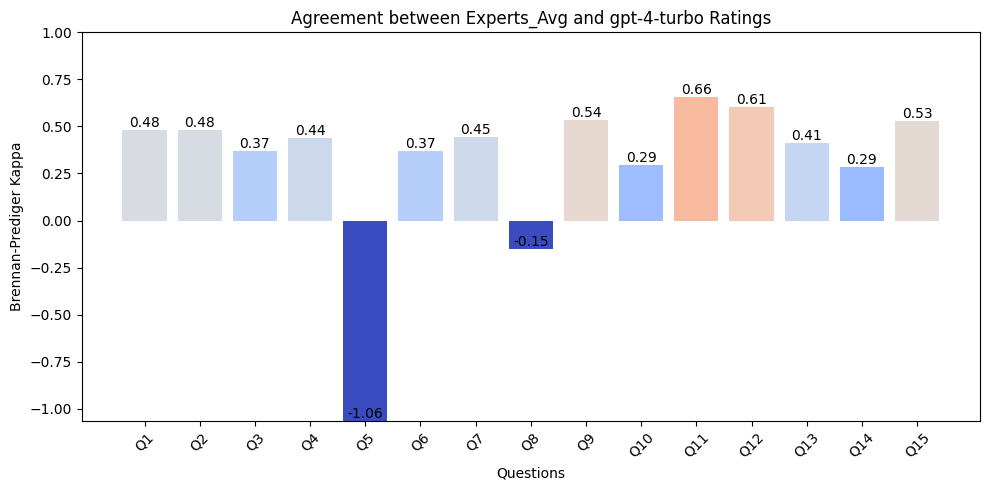

In [24]:
_ = plot_agreement_barplot(model_groupC_df, experts_avg_columns, MODEL_15_SCORE_COLUMNS,
                       'Experts_Avg', model_proper_name,
                       categories, agreement_coef,
                       xlabel='Questions', figsize=(10,5))

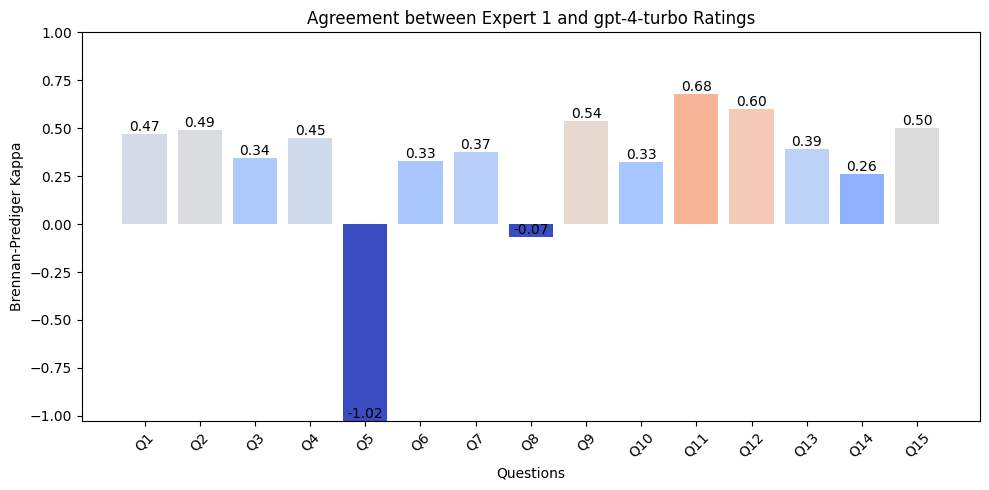

In [25]:
_ = plot_agreement_barplot(model_groupC_df, EXPERT1_COLUMNS, MODEL_15_SCORE_COLUMNS,
                       'Expert 1', model_proper_name,
                       categories, agreement_coef,
                       xlabel='Questions', figsize=(10,5))

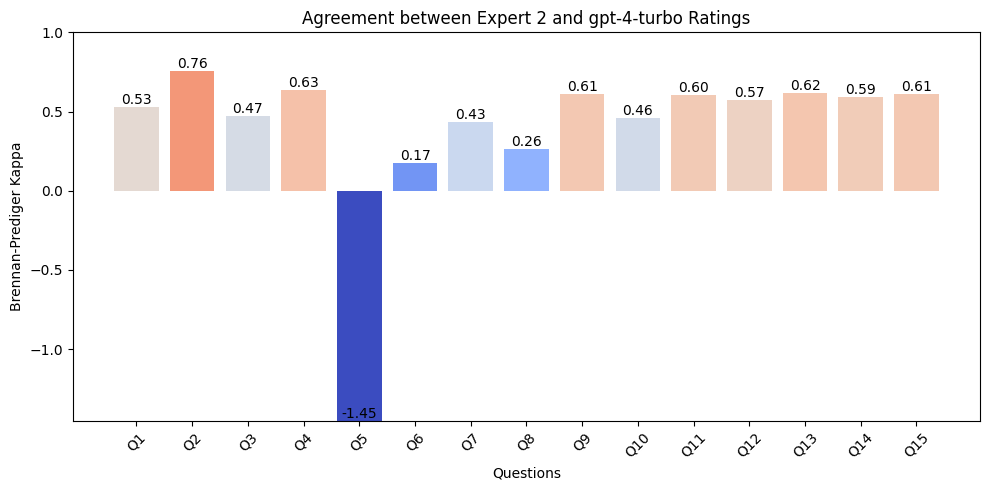

In [26]:
_ = plot_agreement_barplot(model_groupC_df, EXPERT2_COLUMNS, MODEL_15_SCORE_COLUMNS,
                       'Expert 2', model_proper_name,
                       categories, agreement_coef,
                       xlabel='Questions', figsize=(10,5))

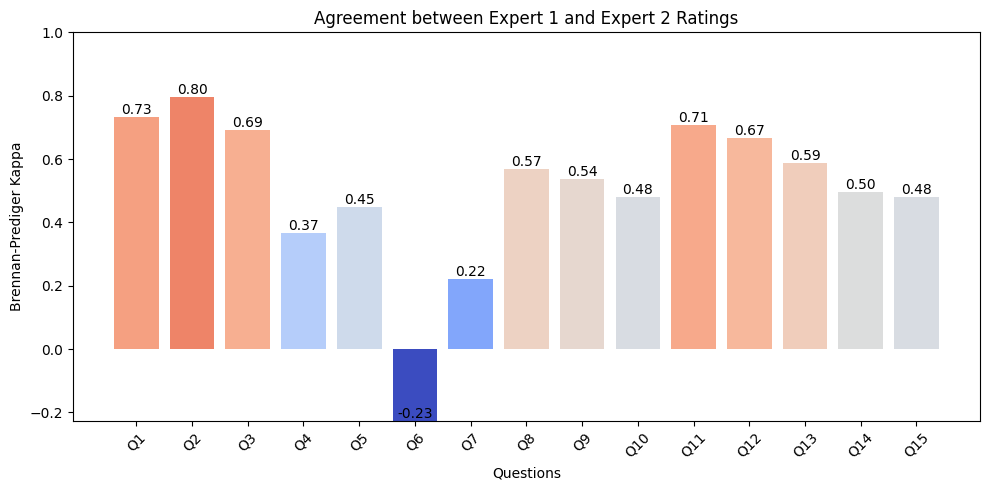

In [28]:
_ = plot_agreement_barplot(model_groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                       'Expert 1', 'Expert 2',
                       categories, agreement_coef,
                       xlabel='Questions', ticklabels=MODEL_15_SCORE_COLUMNS,
                       figsize=(10,5))